###** *Q1**Write a Naïve Bayes Classifier in python without using any direct ML package for the following datasets (1) and (2).**

1.	Dataset of Restaurant customer reviews.
      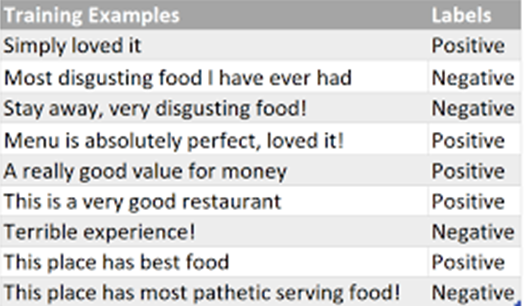

In [110]:
import pandas as pd
df = pd.read_csv("rest.csv")

In [111]:
df['category'] = df['Labels'].apply(lambda x: 1 if x=='Positive' else 0)

In [112]:
df

,Training Examples,Labels,category
0,Simply loved it,Positive,1
1,Most disgusting food I have ever had,Negative,0
2,"Stay away, very disgusting food!",Negative,0
3,"Menu is absolutely perfect, loved it!",Positive,1
4,A reallly good value for money,Positive,1
5,This is a very good restaurant,Positive,1
6,Terrible experience!,Negative,0
7,This place has best food,Positive,1
8,This place has most pathetic serving food!,Negative,0


In [113]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import re
#importing libraries for stemming and tokenizing 
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [114]:
df['Labels'].value_counts(normalize=True)

Positive    0.555556
Negative    0.444444
Name: Labels, dtype: float64

In [115]:
data_randomized = df.sample(frac=1, random_state=1)

# Calculate index for split
training_test_index = round(len(data_randomized) * 1)

# Split into training and test sets
training_set = data_randomized[:training_test_index].reset_index(drop=True)
test_set = data_randomized[training_test_index:].reset_index(drop=True)

print(training_set.shape)
print(test_set.shape)

(9, 3)
(0, 3)


In [116]:
training_set['Labels'].value_counts(normalize=True)

Positive    0.555556
Negative    0.444444
Name: Labels, dtype: float64

In [117]:
test_set['Labels'].value_counts(normalize=True)

Series([], Name: Labels, dtype: float64)

In [118]:
training_set.dtypes

Training Examples    object
Labels               object
category              int64
dtype: object

In [119]:
# After cleaning
training_set['Training Examples'] = training_set['Training Examples'].str.replace('\W', ' ') # Removes punctuation
training_set['Training Examples'] = training_set['Training Examples'].str.lower()
training_set.head(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,Training Examples,Labels,category
0,this place has most pathetic serving food,Negative,0
1,stay away very disgusting food,Negative,0
2,terrible experience,Negative,0


In [120]:
training_set['Training Examples'] = training_set['Training Examples'].str.split()

vocabulary = []
for ex in training_set['Training Examples']:
   for word in ex:
      vocabulary.append(word)

vocabulary = list(set(vocabulary))

In [121]:
len(vocabulary)

32

In [122]:
print(vocabulary)

['money', 'simply', 'it', 'absolutely', 'serving', 'restaurant', 'experience', 'is', 'stay', 'away', 'most', 'very', 'i', 'reallly', 'had', 'has', 'terrible', 'this', 'food', 'a', 'value', 'pathetic', 'have', 'best', 'for', 'perfect', 'ever', 'good', 'loved', 'place', 'menu', 'disgusting']


In [123]:
word_counts_per_rev = {unique_word: [0] * len(training_set['Training Examples']) for unique_word in vocabulary}

for index, rev in enumerate(training_set['Training Examples']):
   for word in rev:
      word_counts_per_rev[word][index] += 1

In [124]:
word_counts = pd.DataFrame(word_counts_per_rev)
word_counts.head(9)

,money,simply,it,absolutely,serving,restaurant,experience,is,stay,away,most,very,i,reallly,had,has,terrible,this,food,a,value,pathetic,have,best,for,perfect,ever,good,loved,place,menu,disgusting
0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1
5,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
6,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0
7,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0
8,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0


In [125]:
training_set_clean = pd.concat([training_set, word_counts], axis=1)
training_set_clean.head()

,Training Examples,Labels,category,money,simply,it,absolutely,serving,restaurant,experience,is,stay,away,most,very,i,reallly,had,has,terrible,this,food,a,value,pathetic,have,best,for,perfect,ever,good,loved,place,menu,disgusting
0,"[this, place, has, most, pathetic, serving, food]",Negative,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0
1,"[stay, away, very, disgusting, food]",Negative,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
2,"[terrible, experience]",Negative,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"[this, place, has, best, food]",Positive,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0
4,"[most, disgusting, food, i, have, ever, had]",Negative,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1


In [126]:
# Isolating postive and negative reviews first
pos_reviews = training_set_clean[training_set_clean['Labels'] == 'Positive']
neg_reviews = training_set_clean[training_set_clean['Labels'] == 'Negative']

# P(postive) and P(negative)
p_pos = len(pos_reviews) / len(training_set_clean)
p_neg = len(neg_reviews) / len(training_set_clean)

# N_postive
n_words_per_pos_review = pos_reviews['Training Examples'].apply(len)
n_pos = n_words_per_pos_review.sum()

# N_negative
n_words_per_neg_review = neg_reviews['Training Examples'].apply(len)
n_neg = n_words_per_neg_review.sum()

# N_Vocabulary
n_vocabulary = len(vocabulary)

# Laplace smoothing
alpha = 1

In [127]:
# Initiate parameters
parameters_pos = {unique_word:0 for unique_word in vocabulary}
parameters_neg = {unique_word:0 for unique_word in vocabulary}

# Calculate parameters
for word in vocabulary:
   n_word_given_posparameters_pos = pos_reviews[word].sum() # posparameters_pos_reviews already defined
   p_word_given_posparameters_pos = (n_word_given_posparameters_pos + alpha) / (n_pos + alpha*n_vocabulary)
   parameters_pos[word] = p_word_given_posparameters_pos

   n_word_given_neg = neg_reviews[word].sum() # neg_reviews already defined
   p_word_given_neg = (n_word_given_neg + alpha) / (n_neg + alpha*n_vocabulary)
   parameters_neg[word] = p_word_given_neg

In [217]:
import re

def categorize(review):
  
   review = re.sub('\W', ' ', review)
   review = review.lower().split()

   p_pos_given_review = p_pos
   p_neg_given_review = p_neg

   for word in review:
      if word in parameters_pos:
         p_pos_given_review *= parameters_pos[word]

      if word in parameters_neg: 
         p_neg_given_review *= parameters_neg[word]

   print('P(pos|review):', p_pos_given_review)
   print('P(neg|review):', p_neg_given_review)

   if p_neg_given_review > p_pos_given_review:
      print('Label: NEGATIVE REVIEW')
   elif p_neg_given_review < p_pos_given_review:
      print('Label: POSITIVE REVIEW')
   else:
      print('Equal proabilities, check yourself')

###Identify the label-> Positive or Negative of the following query by applying NB classifer with Laplace smoothing

In [129]:

test_data1='serving good food absolutely perfect restaurant'
categorize(test_data1)

P(pos|review): 7.004881146323896e-10
P(neg|review): 1.6041768742449525e-10
Label: POSITIVE REVIEW


In [130]:
test_data2='pathetic food ever had'
categorize(test_data2)

P(pos|review): 9.818508406763995e-08
P(neg|review): 1.8024531359016287e-06
Label: NEGATIVE REVIEW


####**Identify the class/category  Politics or Business or Sports - of the following query by applying NB classifer with Laplace smoothing**

(i)	query_data = [4,0,2,0,1,0,6,0]
(ii)	query_data = [0,0,2,0,0,9,0,9] 
(iii)	query_data = [5,0,2,5,0,9,0,9] 


In [199]:
data = pd.read_csv(r'Book6.csv')

In [200]:
#data = data.drop(columns=data.columns[-1])
data.head(10)

,TDP,Nifty,Sidhu,BJP,Sensex,Sixer,Congress,Century,Category
0,4,0,3,5,1,0,6,0,Politics
1,0,5,0,2,6,0,1,0,Business
2,0,0,6,1,0,4,1,2,Sports
3,4,1,0,1,1,0,6,0,Politics
4,0,0,0,0,0,5,0,6,Sports
5,0,4,0,2,6,0,0,1,Business
6,5,0,0,3,0,0,5,0,Politics


In [201]:
query_data= [[4,0,2,0,1,0,6,0],[0,0,2,0,0,9,0,9],[5,0,2,5,0,9,0,9]]

In [202]:
outputcategories = data['Category'].unique()
words = list(data.columns)[:-1]
traindocumentscount = data.shape[0]

In [185]:
print(outputcategories)
print(words)
print(traindocumentscount)

['Politics' 'Business' 'Sports']
['TDP', 'Nifty', 'Sidhu', 'BJP', 'Sensex', 'Sixer', 'Congress', 'Century']
7


In [203]:
conditional_probability = {}
probability = {}

In [204]:
for outputClass in outputcategories:
    temp_dataframe = data.loc[data['Category']==outputClass]
    probability[outputClass]=(temp_dataframe.shape[0]/traindocumentscount)


In [205]:
print(probability)

{'Politics': 0.42857142857142855, 'Business': 0.2857142857142857, 'Sports': 0.2857142857142857}


In [206]:
ALPHA = 1

In [207]:
for outputClass in outputcategories:
    temp_dataframe = data.loc[data['Category']==outputClass]
    total_word_count_in_category =0
    for i in range(temp_dataframe.shape[0]):
        for word in words:
            total_word_count_in_category += temp_dataframe.iloc[i][word]
    for word in words:
        current_word_count_in_category =0
        for i in range(temp_dataframe.shape[0]):
            current_word_count_in_category += temp_dataframe.iloc[i][word]
            cur_prob = (current_word_count_in_category + ALPHA) / (total_word_count_in_category)
            conditional_probability[(word, outputClass)] = cur_prob

In [208]:
print("Conditional probability after applying smoothing\n")
conditional_probability

Conditional probability after applying smoothing



{('BJP', 'Business'): 0.18518518518518517,
 ('BJP', 'Politics'): 0.2222222222222222,
 ('BJP', 'Sports'): 0.08,
 ('Century', 'Business'): 0.07407407407407407,
 ('Century', 'Politics'): 0.022222222222222223,
 ('Century', 'Sports'): 0.36,
 ('Congress', 'Business'): 0.07407407407407407,
 ('Congress', 'Politics'): 0.4,
 ('Congress', 'Sports'): 0.08,
 ('Nifty', 'Business'): 0.37037037037037035,
 ('Nifty', 'Politics'): 0.044444444444444446,
 ('Nifty', 'Sports'): 0.04,
 ('Sensex', 'Business'): 0.48148148148148145,
 ('Sensex', 'Politics'): 0.06666666666666667,
 ('Sensex', 'Sports'): 0.04,
 ('Sidhu', 'Business'): 0.037037037037037035,
 ('Sidhu', 'Politics'): 0.08888888888888889,
 ('Sidhu', 'Sports'): 0.28,
 ('Sixer', 'Business'): 0.037037037037037035,
 ('Sixer', 'Politics'): 0.022222222222222223,
 ('Sixer', 'Sports'): 0.4,
 ('TDP', 'Business'): 0.037037037037037035,
 ('TDP', 'Politics'): 0.3111111111111111,
 ('TDP', 'Sports'): 0.04}

In [209]:
query_dict = {}
list_query_dict = []
for data in query_data:
    for i, word in enumerate(words) :
        query_dict[word] = data[i]
    list_query_dict.append(query_dict)
    query_dict = {}

In [210]:
list_query_dict

[{'BJP': 0,
  'Century': 0,
  'Congress': 6,
  'Nifty': 0,
  'Sensex': 1,
  'Sidhu': 2,
  'Sixer': 0,
  'TDP': 4},
 {'BJP': 0,
  'Century': 9,
  'Congress': 0,
  'Nifty': 0,
  'Sensex': 0,
  'Sidhu': 2,
  'Sixer': 9,
  'TDP': 0},
 {'BJP': 5,
  'Century': 9,
  'Congress': 0,
  'Nifty': 0,
  'Sensex': 0,
  'Sidhu': 2,
  'Sixer': 9,
  'TDP': 5}]

In [211]:
categorical_result_probability = {}
result_probability =[]
for query_dict in list_query_dict:
    for output_class in outputcategories :
        cur_prob = 1
        for word in words :
            cur_prob *= (conditional_probability[(word, output_class)] ** query_dict[word])
            categorical_result_probability[output_class] = cur_prob                  
    result_probability.append(categorical_result_probability)
    categorical_result_probability = {}

In [213]:
result_probability

[{'Business': 2.0530257296565003e-16,
  'Politics': 2.0212765225616147e-08,
  'Sports': 2.1045339750400004e-15},
 {'Business': 1.2077990336473961e-26,
  'Politics': 1.3799701971155752e-32,
  'Sports': 2.0872693292214035e-09},
 {'Business': 1.8331882202741092e-37,
  'Politics': 2.1796398918917e-38,
  'Sports': 7.003713677304523e-22}]

In [215]:
i=1
for categorical_result_probability in result_probability:
    result_category = max(categorical_result_probability, key=categorical_result_probability.get)
    result_score = categorical_result_probability[result_category]
    print(f"The query {i} entered belongs to  : {result_category}")
    i=i+1

The query 1 entered belongs to  : Politics
The query 2 entered belongs to  : Sports
The query 3 entered belongs to  : Sports
